<center><img src="https://github.com/FASSt-simulation/fasst_simulation_tools/raw/main/images/site-logo.png" width=150 height=150 alt="NGEE-Arctic Logo"/></center>

# An example of comparing and plotting one variable from ELM output across multiple cases

#### ----------------------------------------------------------------------------------------------------------------------

<br>

To run this script and generate the resulting ELM plots we need specific Python libraries.  This step loads those required libraries

In [12]:
import matplotlib.pyplot as plt
import xarray
import os
import ipywidgets as widgets
import glob, numpy
import cftime
from cftime import date2num

Next, we locate the output data and identify which sites there is output for. This code creates a dropdown menu to pick the model run you want to plot.

In [2]:
output_rootdir='/mnt/output/cime_run_dirs/'
cases=sorted(glob.glob("%s*20TR*" % output_rootdir))
cases=[os.path.basename(x) for x in cases]
cntl_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Control Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

expt_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Experimental Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)


display(cntl_dropdown)
display(expt_dropdown)

Dropdown(description='Chose Control Case Name:', layout=Layout(width='max-content'), options=('ArcticInit_era5…

Dropdown(description='Chose Experimental Case Name:', layout=Layout(width='max-content'), options=('ArcticInit…

Here, we are using the combined output file over all years of the run. We read in the list of variables, units, and longer descriptions from the dataset. We use the time variable from the dataset to determine the start and end years.

In [4]:
cntl_output_file=output_rootdir + cntl_dropdown.value + '/run/ELM_output.nc'
expt_output_file=output_rootdir + expt_dropdown.value + '/run/ELM_output.nc'

#-------------------------------
# Control case:
# Read in the list of variable, units, and longer descriptions from the dataset
with xarray.open_dataset(cntl_output_file) as cntl_data:
    vars=cntl_data.variables
    vars_names=list(vars.keys())
    units=[cntl_data[var].attrs.get('units',None) for var in vars_names]
    longnames=[cntl_data[var].attrs.get('long_name',None) for var in vars_names]

    description=[f'{var} ({longname}) [{unit}]' for (var,longname,unit) in zip(vars_names,units,longnames)]

    # Determine start and end year of the dataset
    cntl_data_startyear=cntl_data.time[0].item().year
    cntl_data_endyear=cntl_data.time[-1].item().year

vars_dropdown = widgets.Dropdown(options=list(zip(description,vars_names)),
                                description='Choose Variable Name',
                                style={'description_width':'auto'},
                                value='GPP',
                                layout={'width':'max-content'},
                                disabled=False)
startyear_picker = widgets.BoundedIntText(value=cntl_data_startyear, min=cntl_data_startyear, max=cntl_data_endyear, step=1,
                                          description='Choose start year',style={'description_width':'auto'})
endyear_picker = widgets.BoundedIntText(value=cntl_data_endyear, min=cntl_data_startyear, max=cntl_data_endyear, step=1,
                                          description='Choose end year',style={'description_width':'auto'})

display(vars_dropdown)
display(startyear_picker)
display(endyear_picker)

#-------------------------
# Get data for experimental case:
# Read in the list of variable, units, and longer descriptions from the dataset
with xarray.open_dataset(expt_output_file) as expt_data:
    expt_vars=expt_data.variables



Dropdown(description='Choose Variable Name', index=186, layout=Layout(width='max-content'), options=(('mcdate …

BoundedIntText(value=1850, description='Choose start year', max=2016, min=1850, style=DescriptionStyle(descrip…

BoundedIntText(value=2016, description='Choose end year', max=2016, min=1850, style=DescriptionStyle(descripti…

Using the fields above, you can pick the variable that you want to plot, and the start and end year of the time series to visualize.

Next, we read the variable from the dataset and select the time portion based on start and end year picked above.

In [17]:
year_start=startyear_picker.value
year_end=endyear_picker.value
var=vars_dropdown.value

with xarray.open_dataset(cntl_output_file).squeeze() as output:
    if 'time' not in output[var].dims:
        print(f'Variable {var} is not a time-series variable! Plotting will not work.')
    else:
        cntl_vardata=output[var].sel(time=slice(str(year_start),str(year_end)))
    
    if 'PFTnames' in output:
        print('Output file is separated by plant functional type')
        PFTnames=output['PFTnames']
    else:
        PFTnames=[]
        
with xarray.open_dataset(expt_output_file).squeeze() as output:
    if 'time' not in output[var].dims:
        print(f'Variable {var} is not a time-series variable! Plotting will not work.')
    else:
        expt_vardata=output[var].sel(time=slice(str(year_start),str(year_end)))
    
    if 'PFTnames' in output:
        print('Output file is separated by plant functional type')
        PFTnames=output['PFTnames']
    else:
        PFTnames=[]


Finally, we will create a figure and plot the variable. The code checks whether it is depth-defined or not. For depth-defined variables, it plots a two-dimensional time vs depth plot. Otherwise, it plots a time series. For model output that shows each plant functional type individually, it plots the plant functional types separately.

Variable is depth-defined. Plotting in two dimensions


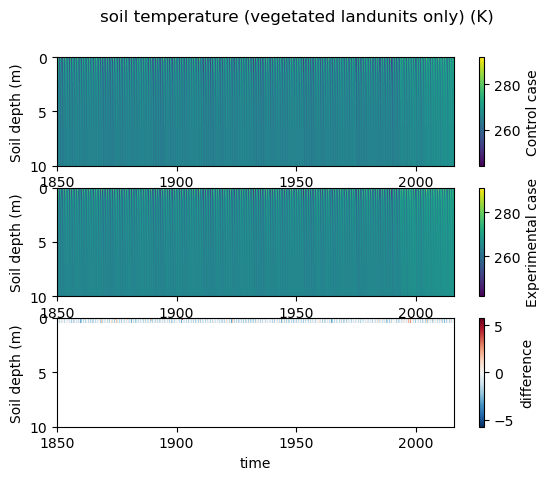

In [21]:
if 'levgrnd' in cntl_vardata.dims or 'levdcmp' in cntl_vardata.dims:
    print('Variable is depth-defined. Plotting in two dimensions')
    f, (a1, a2, a3) = plt.subplots(3, 1, sharey=False)
    cntl_vardata.T.plot(ax=a1, cbar_kwargs={'label':'Control case'})
    expt_vardata.T.plot(ax=a2, cbar_kwargs={'label':'Experimental case'})
    diff = expt_vardata-cntl_vardata
    diff.T.plot(ax=a3, cbar_kwargs={'label':'difference'})
    maxdepth=10.0
    a1.set_ylim(maxdepth,0.0)
    a1.set_ylabel('Soil depth (m)')
    a2.set_ylim(maxdepth,0.0)
    a2.set_ylabel('Soil depth (m)')
    a3.set_ylim(maxdepth,0.0)
    a3.set_ylabel('Soil depth (m)')
    varname=cntl_vardata.attrs['long_name']
    units=cntl_vardata.attrs['units']
    plt.suptitle(f'{varname} ({units})')
elif 'PFT' in cntl_vardata.dims:
    print('Variable is defined by plant functional type. Plotting one line per PFT')
    print('No plot specified for this variable!')
else:
    print('Variable is not depth-defined. Plotting line plot.')
    f,(a1,a2) = plt.subplots(1, 2, sharey=False)
    cntl_vardata.plot(ax=a1, label = 'Control case')
    expt_vardata.plot(ax=a1, label = 'Experimental case')
    varname=cntl_vardata.attrs['long_name']
    units=cntl_vardata.attrs['units']
    a1.set_ylabel(f'{varname} ({units})')
    a1.set_xlabel('Time')
    a1.legend(loc = 'upper right')
    diff=expt_vardata-cntl_vardata
    diff.plot(ax=a2, label = "difference") 
    a2.set_ylabel(f'difference in {varname}')
    a2.set_xlabel('Time')
    

In [20]:
cntl_vardata

<xarray.DataArray 'TSOI' (time: 60591, levgrnd: 15)> Size: 4MB
[908865 values with dtype=float32]
Coordinates:
  * time     (time) object 485kB 1850-01-01 00:00:00 ... 2016-01-01 00:00:00
  * levgrnd  (levgrnd) float32 60B 0.007101 0.02792 0.06226 ... 21.33 35.18
Attributes:
    long_name:      soil temperature (vegetated landunits only)
    standard_name:  soil_temperature
    units:          K
    cell_methods:   time: mean

<center><img src="https://github.com/FASSt-simulation/fasst_simulation_tools/raw/main/images/site-logo.png" width=150 height=150 alt="NGEE-Arctic Logo"/></center>